# Généralisation robuste de LDA/QDA

Andrew Wang

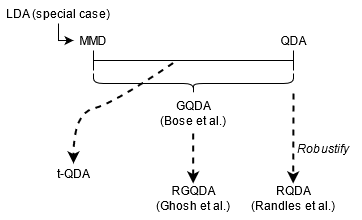

Méthodes classiques: MMD, (LDA,) QDA  
Méthodes génerales: GQDA (qui généralise le regle de classification pour les distributions ES avec la variable c qui interpole entre 0 (MMD) et 1 (QDA))  
Méthodes robustes: RQDA (utilisant le regle QDA mais avec estimation robuste - on peut compter M-estimator, MVE, MCD, S-estimator optimal(selon Croux et al.), etc  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;RGQDA  
Cas particulier: t-QDA (la variable c calculée en termes de DOFs, estimation robuste avec EM)  

QDA avec ES: estimation des parametres avec le meme EM (mais avec E-step fixé) et calculation des posteriors avec le E-step

In [1]:
import numpy as np
import random 
import pandas as pd
import os
import time
import csv 
import warnings

# MATH and STATS:
import math

# PLOT:
import matplotlib.pyplot as plt
from plotnine import *
from plotnine.data import *
%matplotlib inline

# SKLEARN:
from sklearn import metrics # AMII and ARI
from sklearn import decomposition #PCA
from sklearn import discriminant_analysis
from scipy import stats, special, optimize
from sklearn.model_selection import train_test_split
# EMBEDDINGs:
import umap
warnings.filterwarnings('ignore') # AMI warning

In [2]:
from import_subset_datasets import *
from clustering_accuracy import acc
from vis import *
from dataset_utils import *
from models import *

In [3]:
%run vis

In [4]:
def run_all(X, y, X_test, y_test):
    print("LDA")
    ldatest = LDA(method='generalised')#discriminant_analysis.LinearDiscriminantAnalysis()
    ldatest.fit(X, pd.Series(y))
    print_metrics(pd.Series(y_test), ldatest.predict(X_test))
    print("QDA")
    qdatest = QDA(method='generalised')#discriminant_analysis.QuadraticDiscriminantAnalysis()
    qdatest.fit(X, pd.Series(y))
    print_metrics(pd.Series(y_test), qdatest.predict(X_test))
    print("t-LDA")
    t_ldatest = t_LDA(method='generalised')
    t_ldatest.fit(X, pd.Series(y))
    print_metrics(pd.Series(y_test), t_ldatest.predict(X_test))
    print("t-QDA")
    t_qdatest = t_QDA(method='generalised')
    t_qdatest.fit(X, pd.Series(y))
    print_metrics(pd.Series(y_test), t_qdatest.predict(X_test))
    print("GQDA")
    gqdatest = GQDA()
    gqdatest.fit(X, pd.Series(y))
    print_metrics(pd.Series(y_test), gqdatest.predict(X_test))
    print("RGQDA")
    rgqdatest = RGQDA('M-estimator')
    rgqdatest.fit(X, pd.Series(y))
    print_metrics(pd.Series(y_test), rgqdatest.predict(X_test))
    print("RGQDA-S")
    rgqdastest = RGQDA('S-estimator')
    rgqdastest.fit(X, pd.Series(y))
    print_metrics(pd.Series(y_test), rgqdastest.predict(X_test))
    print("RQDA-M")
    rqdatest = RGQDA('M-estimator')
    rqdatest.fit(X, pd.Series(y), c=1)
    print_metrics(pd.Series(y_test), rqdatest.predict(X_test))
    print("RQDA-S")
    rqdastest = RGQDA('S-estimator')
    rqdastest.fit(X, pd.Series(y), c=1)
    print_metrics(pd.Series(y_test), rqdastest.predict(X_test))
    return ldatest, qdatest, t_ldatest, t_qdatest, gqdatest, rgqdatest, rgqdastest, rqdatest, rqdastest

## MNIST

### Prepare MNIST data

In [5]:
np.random.seed(44)
random.seed(44)

#read_mnist_train = pd.read_csv(r"data\mnist_train.csv")
#read_mnist_test = pd.read_csv(r"data\mnist_test.csv")

read_mnist_train = pd.read_csv(r"data\fashion-mnist_train.csv")
read_mnist_test = pd.read_csv(r"data\fashion-mnist_test.csv")

In [6]:
mnist_labels_raw = read_mnist_train.iloc[:, 0]

mnist_data = read_mnist_train.iloc[:, 1:]

selected_digits = [0,2,3,4,6]
selected_digits_2 = [1,4]

mnist_pca, mnist_labels, mnist_raw, ve, pca = import_subset(mnist_data, mnist_labels_raw, selected_digits,30, 800)
#mnist_pca_2, mnist_labels_2, mnist_raw_2, ve2, pca2 = import_subset(mnist_data, mnist_labels_raw, selected_digits_2, 30, 800)

In [7]:
# Transform test data
mnist_test_labels_raw = read_mnist_test.iloc[:, 0]
mnist_test_data = read_mnist_test.iloc[:, 1:]
mnist_test_pca, mnist_test_labels, mnist_test_raw,_,_2 = import_subset(mnist_test_data, mnist_test_labels_raw, selected_digits, 30, 400, pca=pca)

In [8]:
mapper = umap.UMAP(metric='euclidean')
embedding = mapper.fit_transform(mnist_pca)

label = pd.Series(mnist_labels)
em = pd.DataFrame(embedding, columns=['A','B']) 
em['label'] = label.astype(str)
gg = ggplot(aes(x='A', y='B', color='label'), data=em)+geom_point()+ scale_color_discrete(guide=False)+ labs(x = "", y = "") 
#gg.save("MNIST38_real.png",dpi =300)

In [9]:
ret =  lda_grid(em, mapper)
%store ret

Stored 'ret' (tuple)


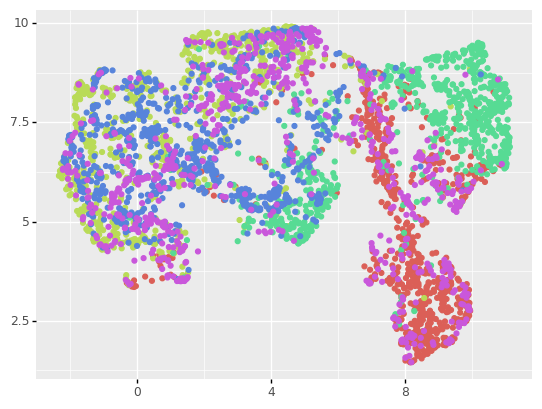

<ggplot: (125167755493)>

In [10]:
gg

### Pure MNIST test

In [11]:
models_MNIST_pure = run_all(mnist_pca, mnist_labels, mnist_test_pca, mnist_test_labels)

LDA
Accuracy 0.723
ARI 0.45374
AMI 0.46753
QDA
Accuracy 0.734
ARI 0.48004
AMI 0.48223
t-LDA
Accuracy 0.4575
ARI 0.08521
AMI 0.23068
t-QDA
Accuracy 0.656
ARI 0.35359
AMI 0.43304
GQDA
optimal c is 0.49860251442480774
Accuracy 0.7465
ARI 0.49395
AMI 0.49339
RGQDA
optimal c is 0.8311971646188815
Accuracy 0.7295
ARI 0.46373
AMI 0.4717
RGQDA-S
optimal c is 0.4358970554428034
Accuracy 0.7125
ARI 0.4273
AMI 0.44851
RQDA-M
Accuracy 0.725
ARI 0.45994
AMI 0.46928
RQDA-S
Accuracy 0.7105
ARI 0.43114
AMI 0.44914


### MNIST with mislabelling test

In [24]:
# Mislabel
mnist_labels_mislabelled = mislabelled(800, 0.1, np.unique(mnist_labels))

In [25]:
models_MNIST_mislabelled = run_all(mnist_pca, mnist_labels_mislabelled, mnist_test_pca, mnist_test_labels)

LDA
Accuracy 0.728
ARI 0.45858
AMI 0.46924
QDA
Accuracy 0.739
ARI 0.48313
AMI 0.48025
t-LDA
Accuracy 0.497
ARI 0.16308
AMI 0.23948
t-QDA
Accuracy 0.6585
ARI 0.36092
AMI 0.42987
GQDA
optimal c is 0.710615184946564
Accuracy 0.7465
ARI 0.49294
AMI 0.48841
RGQDA
optimal c is 0.9125517343725857
Accuracy 0.7305
ARI 0.46812
AMI 0.47177
RGQDA-S
optimal c is 0.49062256753231104
Accuracy 0.72
ARI 0.4461
AMI 0.45993
RQDA-M
Accuracy 0.7275
ARI 0.46511
AMI 0.46833
RQDA-S
Accuracy 0.7125
ARI 0.43849
AMI 0.45527


## Sklearn discriminant analysis

### Sklearn LDA

In [14]:
lda = discriminant_analysis.LinearDiscriminantAnalysis(store_covariance=True)
lda.fit(mnist_pca, label)
print_metrics(pd.Series(mnist_test_labels), lda.predict(mnist_test_pca))

Accuracy 0.723
ARI 0.45374
AMI 0.46753


(2500, 30)


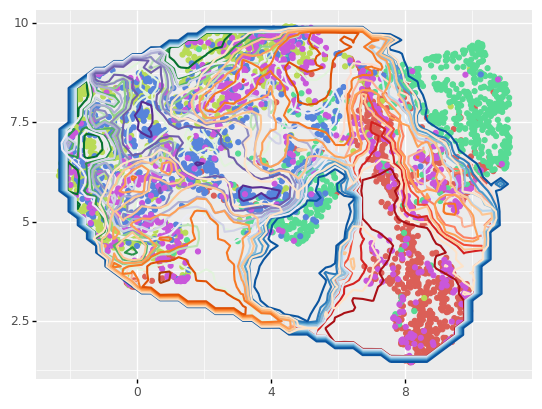

In [15]:
plot_contours_UMAP(gg, lda, *ret)

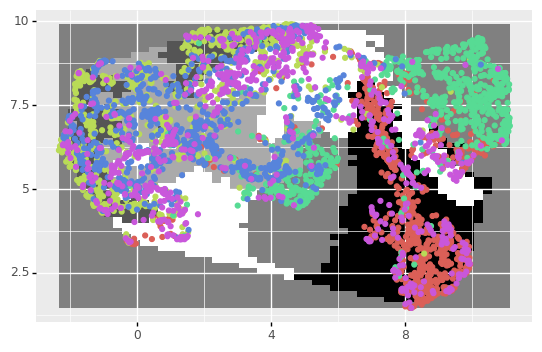

In [16]:
plot_regions_UMAP(gg, lda, *ret)

### Sklearn QDA

In [17]:
qda = discriminant_analysis.QuadraticDiscriminantAnalysis()
qda.fit(mnist_pca, label)
print_metrics(pd.Series(mnist_test_labels), qda.predict(mnist_test_pca))

Accuracy 0.734
ARI 0.48004
AMI 0.48223


## Synthetic Data

In [18]:
np.random.seed(seed=233423)

In [20]:
def synthesise(n, contamination=0, mislabelling=0): #contamination, mislabelling percent
    hard = False
    X1 = contaminated(n, stats.multivariate_t, contamination, loc=np.array([1, 1, 1, 1, 1, 1 ]), shape=np.eye(6), df=1, hard=hard) #cauchy
    X2 = contaminated(n, stats.multivariate_t, contamination, loc=np.array([-1,-1,-1, 1, 1, 1]), shape=np.eye(6), df=3, hard=hard) #t
    X3 = contaminated(n, stats.multivariate_t, contamination, loc=np.array([1, 1, 1, -1,-1,-1]), shape=np.eye(6), df=20, hard=hard) #normal
    X4 = contaminated(n, stats.multivariate_t, contamination, loc=np.array([-1,-1,-1,-1,-1,-1]), shape=np.eye(6), df=1, hard=hard) #cauchy
    
    return np.vstack([X1, X2, X3, X4]), mislabelled(n, mislabelling, np.arange(4))

In [21]:
X,y = synthesise(1000, contamination=0.05, mislabelling=0.05)

In [22]:
X_test,y_test = synthesise(1000)

In [23]:
models_synth = run_all(X,y,X_test,y_test)

LDA
Accuracy 0.698
ARI 0.37779
AMI 0.37287
QDA
Accuracy 0.2915
ARI 0.00749
AMI 0.05854
t-LDA
Accuracy 0.65025
ARI 0.30696
AMI 0.41142
t-QDA
Accuracy 0.69775
ARI 0.36768
AMI 0.44658
GQDA
optimal c is 0.16711980479561914
Accuracy 0.391
ARI 0.05215
AMI 0.12641
RGQDA
optimal c is 0.7714645781170741
Accuracy 0.787
ARI 0.51471
AMI 0.48792
RGQDA-S
optimal c is 0.9930654711891523
Accuracy 0.78175
ARI 0.51599
AMI 0.47764
RQDA-M
Accuracy 0.77825
ARI 0.50691
AMI 0.4697
RQDA-S
Accuracy 0.78125
ARI 0.51525
AMI 0.47726


In [ ]:
#plt.scatter(X[:,0],X[:,1])
#plot_contours(X, t_qdatest.predict_proba, plt.gca())

## Statlog test

In [ ]:
read_statlog = pd.read_csv(r"data\statlog.csv")
statlog_labels = read_statlog.iloc[:, 0]
statlog_data = read_statlog.iloc[:, 1:]

In [ ]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(
...     X, y, test_size=0.33, random_state=42)

## NORB test

### Prepare NORB data

In [ ]:
from smallnorb import *

In [ ]:
NORB = SmallNORBDataset(dataset_root='data/')

datiss = NORB._parse_NORB_dat_file('data/smallnorb-5x46789x9x18x6x2x96x96-training-dat.mat')
NORB_datos = np.reshape(datiss, (48600, 9216,)) #each image in a row
NORB_datos_lt = NORB_datos[::2, :] #only left image

NORB_labels = NORB._parse_NORB_cat_file('data/smallnorb-5x46789x9x18x6x2x96x96-training-cat.mat')

In [ ]:
np.random.seed(44)
random.seed(44)

#categories = ['human', 'airplane', 'truck', 'car']
selected_cat = [1, 2, 3, 4]
n_sample = 400
n_pca = 30

#NORB_norm = NORB_datos_lt - NORB_datos_lt.mean(axis=1).reshape(-1, 1) 

NORB_datos_lt = pd.DataFrame(NORB_datos_lt)
#NORB_datos_lt = pd.DataFrame(NORB_norm)

NORB_pca, NORB_labels_sel, NORB_raw, ve, _ = import_subset(NORB_datos_lt, NORB_labels, selected_cat, 30, 400)

In [ ]:
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,   
    left=False,
    labelleft=False,
    labelbottom=False)
plt.imshow(np.reshape(1-np.array(NORB_raw.iloc[100])/255, (96, 96)), cmap="binary")

In [ ]:
norb_embedding = umap.UMAP(random_state = 44, metric='euclidean').fit_transform(NORB_pca)

norb_label = pd.Series(NORB_labels_sel)
norb_em = pd.DataFrame(norb_embedding, columns=['A','B']) 
norb_em['labels'] = norb_label.astype(str)
norb_gg = ggplot(aes(x='A', y='B', color='labels'), data=norb_em)+geom_point()+ylab("")+xlab("")+ scale_color_discrete(guide=False)
norb_gg

### Pure NORB test

In [ ]:
models_NORB_pure = run_all(NORB_pca, NORB_labels_sel, #?? create NORB test data

In [ ]:
for c in np.linspace(0.01,1,100):
    test_gqda.c = c
    accuracies += [acc(pd.Series(y).astype(int), test_gqda.predict(X_test).astype(int))]

In [ ]:
test_gqda.c = 1
test_gqda.fudge = 0
acc(pd.Series(y).astype(int), test_gqda.predict(X_test).astype(int))

In [ ]:
plt.scatter(X[:,0],X[:,1])
plot_contours(X, test_gqda.predict_proba, plt.gca())